### Présentation
'https://1drv.ms/p/s!AlsBeFXBhA-Dg6MCggAda_77bR-NIA?e=zLdG85'

### Présentation lors du brainstorming
'https://1drv.ms/b/s!AlsBeFXBhA-Dg44dmDhrVa6gIHPYwQ?e=mi1zIn'

In [17]:
import nibabel as nib
import numpy as np
import os
import pandas as pd 
import glob
from sklearn.linear_model import LinearRegression
from scipy import stats
import plotnine as p9
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import statsmodels.api as sm
from radiomics import featureextractor
from scipy import stats

In [18]:
def getCQT1AndMultiTE(ptID):
    retT1=-1;retT2=-1
    fh = open(os.path.join(STUDY_PATH,'CQData20200406.csv'))
    reader = csv.reader(fh, delimiter = ';')

    for ligne in reader:
        if ligne[0]==ptID:
            retT1=ligne[1]
            retT2=ligne[2]
            break

    return retT1,retT2 
#df = pd.read_csv(file_name,sep = ';')

In [19]:
def unconfound(y, confound, group_data=False):
    """
    This will remove the influence "confound" has on "y".
    If the data is made up of two groups, the group label (indicating the group) must be the first column of
    'confound'. The group label will be considered when fitting the linear model, but will not be considered when
    calculating the residuals.
    Args:
        y: [samples, targets]
        confound: [samples, confounds]
        group_data: if the data is made up of two groups (e.g. for t-test) or is just
                    one group (e.g. for correlation analysis)
    Returns:
        y_correct: [samples, targets]
    """
    # Demeaning beforehand or using intercept=True has similar effect
    #y = demean(y)
    #confound = demean(confound)

    lr = LinearRegression(fit_intercept=True).fit(confound, y)  # lr.coef_: [targets, confounds]
    if group_data:
        y_predicted_by_confound = lr.coef_[:, 1:] @ confound[:, 1:].T
    else:
        y_predicted_by_confound = lr.coef_ @ confound.T  # [targets, samples]
    y_corrected = y.T - y_predicted_by_confound
    return y_corrected.T  # [samples, targets]

In [39]:
STUDY_PATH="/NAS/deathrow/protocoles/predistim/"
#STUDY_PATH=os.path.join('D:','LINUX','Predistim')

### Lecture du fichier de données genomique

In [113]:
GenomicData = pd.read_excel(os.path.join(STUDY_PATH,'SNPs_Predistim.xlsx'),usecols=["NUM_PAT","SNP_ACSL4","SNP_GPx4","cluster_SNP"],index_col=0)
print("n = ",len(GenomicData))

n =  637


In [114]:
#GenomicData=GenomicData.loc[GenomicData.notnull()]
#GenomicData=GenomicData.dropna()
#ClinicalData.loc[ClinicalData[col].notnull()]
#GenomicData.describe

### Lecture du fichier de données démographique (extraction du 22/06/2020)

In [115]:
ClinicalData = pd.read_excel(os.path.join(STUDY_PATH,'Data_Cli_2020_06_22.xlsx'),index_col=[1])
print("n = ",len(ClinicalData))

n =  834


In [116]:
#list_Cli_Gen=GenomicData.index.intersection(ClinicalData.index)
#ClinicalData=ClinicalData.loc[list_Cli_Gen]
#GenomicData=GenomicData.loc[list_Cli_Gen]

Cli_Gen_data=ClinicalData.join(GenomicData)
Cli_Gen_data=Cli_Gen_data.set_index(['PatientID'])

### Covariable candidate

In [112]:
ClinicalData.columns[0:7]

Index(['PatientID', 'Age', 'Duree', 'Poids', 'BMI', 'MOCA', 'Sexe'], dtype='object')

### Score à predire ou corréler

In [119]:
ClinicalData.columns[7:13]

Index(['Centre', 'UPDRS-III_Tot', 'DOPA', 'HOEHN_YAHR_ON', 'HOEHN_YAHR_OFF',
       'SCHWAB_ON'],
      dtype='object')

### Nombre de patients ayant un CQ T1 et multiTE > 2

In [129]:
nbSUBJ_R2_badCQ=0
nbSUBJ_R2=0
nbSUBJ_QSM=0
nbSUBJ_QSM_badCQ=0
liste_SUBJ_1=[]
for SUBJ in ClinicalData.set_index(['PatientID']).index:
#    print(SUBJ)
#    CQT1=0;CQTE=0
    CQT1,CQTE=getCQT1AndMultiTE(SUBJ)
    try:
        if ((int(CQT1)>-1) & (int(CQTE)>-1)) :
            nbSUBJ_R2_badCQ=nbSUBJ_R2_badCQ+1
            if (SUBJ.startswith('01') | SUBJ.startswith('17') | SUBJ.startswith('19')):
                nbSUBJ_QSM_badCQ=nbSUBJ_QSM_badCQ+1
        if ((int(CQT1)>2) & (int(CQTE)>2)) :
            nbSUBJ_R2=nbSUBJ_R2+1
            liste_SUBJ_1.append(SUBJ)
            if (SUBJ.startswith('01') | SUBJ.startswith('17') | SUBJ.startswith('19')):
                nbSUBJ_QSM=nbSUBJ_QSM+1
    except ValueError:
        print("String is not Numeric: " + SUBJ)
print("\nR2")
print("Acquisition MultiTE : ",nbSUBJ_R2_badCQ)
print("Acquisition avec CQ T1 et CQ multiTE > 2 : ",nbSUBJ_R2)
print("\nQSM")
print("Acquisition MultiTE Philips : ",nbSUBJ_QSM_badCQ)
print("Acquisition Philips avec CQ T1 et CQ multiTE > 2 : ",nbSUBJ_QSM)

String is not Numeric: 14007BP
String is not Numeric: 19017KA

R2
Acquisition MultiTE :  544
Acquisition avec CQ T1 et CQ multiTE > 2 :  400

QSM
Acquisition MultiTE Philips :  173
Acquisition Philips avec CQ T1 et CQ multiTE > 2 :  116


In [13]:
print
ClinicalData = pd.read_excel(os.path.join(STUDY_PATH,'Data_Cli_2020_06_22.xlsx'),index_col=0)

#Supp sub avec un CQ Imagerie non conlcuant
for index,row in ClinicalData.iterrows():    
    if not (os.path.isfile(os.path.join(STUDY_PATH,'R2',index,'R2_nonlin_atlas.nii'))) :
        ClinicalData.drop(index,inplace=True)
print("CQ T1 et Multi TE > 2 :",len(ClinicalData))
liste_SUBJ_2=ClinicalData.index
for col in ['HOEHN_YAHR_ON','HOEHN_YAHR_OFF','SCHWAB_ON','SCHWAB_OFF']:
    ind1=ClinicalData.loc[ClinicalData[col]>=0].index
    ind2=ClinicalData.loc[ClinicalData[col].notnull()].index
    ClinicalData=ClinicalData.loc[ind1.intersection(ind2)]

ind1=ClinicalData.loc[ClinicalData['DOPA']>0].index
ind2=ClinicalData.loc[ClinicalData['DOPA'].notnull()].index
ClinicalData=ClinicalData.loc[ind1.intersection(ind2)]

#ClinicalData=ClinicalData['Duree'].dropna()
print("Après suppression des données manquantes :",len(ClinicalData))
    
#La BMI supprime trop de sujet
#ClinicalData.loc[ClinicalData['BMI'].isnull()]

ClinicalData.to_csv(os.path.join(STUDY_PATH,'subj4R2.csv'),sep='\t')

CQ T1 et Multi TE > 2 : 361
Après suppression des données manquantes : 302


Données manquantes 

In [23]:
list_ptperdu=list(set(liste_SUBJ_1)-set(liste_SUBJ_2))
list_ptperdu.sort()
print(len(list_ptperdu))


39


In [36]:
CMD="fsladd "+os.path.join(STUDY_PATH,'QSM','meanQSM')+" -m "
for SUBJ in liste_SUBJ_2:
    if (SUBJ.startswith('01') | SUBJ.startswith('17') | SUBJ.startswith('19')):
        if os.path.isfile(os.path.join(STUDY_PATH,'QSM',SUBJ,'QSM_nonlin_atlas.nii')):
            CMD=CMD+" "+os.path.join(STUDY_PATH,'QSM',SUBJ,'QSM_nonlin_atlas.nii')
print(CMD)

fsladd /NAS/deathrow/protocoles/predistim/QSM/meanQSM -m  /NAS/deathrow/protocoles/predistim/QSM/01011BB/QSM_nonlin_atlas.nii /NAS/deathrow/protocoles/predistim/QSM/01014DE/QSM_nonlin_atlas.nii /NAS/deathrow/protocoles/predistim/QSM/01015HC/QSM_nonlin_atlas.nii /NAS/deathrow/protocoles/predistim/QSM/01016BP/QSM_nonlin_atlas.nii /NAS/deathrow/protocoles/predistim/QSM/01017TA/QSM_nonlin_atlas.nii /NAS/deathrow/protocoles/predistim/QSM/01018MT/QSM_nonlin_atlas.nii /NAS/deathrow/protocoles/predistim/QSM/01019LJ/QSM_nonlin_atlas.nii /NAS/deathrow/protocoles/predistim/QSM/01020VM/QSM_nonlin_atlas.nii /NAS/deathrow/protocoles/predistim/QSM/01023CF/QSM_nonlin_atlas.nii /NAS/deathrow/protocoles/predistim/QSM/01024FC/QSM_nonlin_atlas.nii /NAS/deathrow/protocoles/predistim/QSM/01025RE/QSM_nonlin_atlas.nii /NAS/deathrow/protocoles/predistim/QSM/01026AF/QSM_nonlin_atlas.nii /NAS/deathrow/protocoles/predistim/QSM/01027TM/QSM_nonlin_atlas.nii /NAS/deathrow/protocoles/predistim/QSM/01028SA/QSM_nonlin_

In [126]:
print("QSM")
ClinicalData = pd.read_excel(os.path.join(STUDY_PATH,'Data_Cli_2020_06_22.xlsx'),index_col=0)

#Supp sub avec un CQ Imagerie non conlcuant
for index,row in ClinicalData.iterrows():    
    if not (os.path.isfile(os.path.join(STUDY_PATH,'QSM',index,'QSM_nonlin_atlas.nii'))) :
        ClinicalData.drop(index,inplace=True)
print("CQ T1 et Multi TE > 2 :",len(ClinicalData))

for col in ['HOEHN_YAHR_ON','HOEHN_YAHR_OFF','SCHWAB_ON','SCHWAB_OFF']:
    ind1=ClinicalData.loc[ClinicalData[col]>=0].index
    ind2=ClinicalData.loc[ClinicalData[col].notnull()].index
    ClinicalData=ClinicalData.loc[ind1.intersection(ind2)]
    #print(len(ClinicalData))

ind1=ClinicalData.loc[ClinicalData['DOPA']>0].index
ind2=ClinicalData.loc[ClinicalData['DOPA'].notnull()].index
ClinicalData=ClinicalData.loc[ind1.intersection(ind2)]

print("Après suppression des données manquantes :",len(ClinicalData))

ClinicalData.to_csv(os.path.join(STUDY_PATH,'subj4QSM.csv'),sep='\t')

QSM
CQ T1 et Multi TE > 2 : 98
Après suppression des données manquantes : 85


### Extraction des valeurs moyennes par ROI
QSM du sujet réaligné sur le T1 : QSM/19052BG/QSM_lin_3DT1.nii.gz
R2 du sujet réaligné sur le T1 : R2/19052BG/R2_lin_3DT1.nii.gz

In [131]:
ClinicalData = pd.read_excel(os.path.join(STUDY_PATH,'Data_Cli_2020_06_22.xlsx'),index_col=0)
values=np.zeros(shape=(len(df),8),dtype=float)

#Supp sub avec un CQ Imagerie non conlcuant
for index,row in ClinicalData.iterrows():    
    if (SUBJ.startswith('01') | SUBJ.startswith('17') | SUBJ.startswith('19')):
        CQT1,CQTE=getCQT1AndMultiTE(SUBJ)
        if not (os.path.isfile(os.path.join(STUDY_PATH,'QSM',index,'QSM_nonlin_atlas.nii'))) :
            ClinicalData.drop(index,inplace=True)            
        elif not ((int(CQT1)>2) & (int(CQTE)>2)) :
            ClinicalData.drop(index,inplace=True)
        else :
            img = nib.load(os.path.join(STUDY_PATH,PARA,SUBJ,PARA+'_lin_3DT1.nii.gz'))
            img_data=np.asanyarray(img.dataobj)
            #VOLBRAIN caudé 3/4, Putamen 5/6, thalamus 7/8, Globus pallidus 9/10, hipocampus 11/12, amigdala 13/14
            struct = nib.load(os.path.join(STUDY_PATH,'volbrain','native_'+SUBJ,'native_lab_'+SUBJ+'_resliced.nii.gz'))
            struct_data=np.asanyarray(struct.dataobj)
            break 
            for cpt,cpt1,cpt2 in zip(np.arange(0,7,1),np.arange(1,16,2),np.arange(2,17,2)):
                tmp = ((struct_data==cpt1) | (struct_data==cpt2))
                values[ind,cpt]=np.mean(img_data[tmp])
    else :
        ClinicalData.drop(index,inplace=True)

In [58]:
def getValueAndSetInDataFrame(values,sub,struct):
    per_list=[0,1,5,25,50,75,95,99,100]
    per=np.percentile(values,per_list)
    for cpt,per_val in enumerate(per_list):
        Cli_Gen_data.loc[sub,PARA+"_p"+str(per_val)+"_"+struct]=per[cpt]
    firstOrder=stats.describe(values)
    Cli_Gen_data.loc[sub,PARA+"_skweness_"+struct]=firstOrder.skewness
    Cli_Gen_data.loc[sub,PARA+"_variance_"+struct]=firstOrder.variance
    Cli_Gen_data.loc[sub,PARA+"_kurtosis_"+struct]=firstOrder.kurtosis

#extractor = featureextractor.RadiomicsFeatureExtractor()
#result = extractor.execute(os.path.join(STUDY_PATH,PARA,SUBJ,PARA+'_lin_3DT1.nii.gz'),os.path.join(STUDY_PATH,'volbrain','native_'+SUBJ,'native_lab_'+SUBJ+'_resliced.nii.gz'))


### Test Pyradiomics
#pyradiomics ../../R2/01011BB/R2_lin_3DT1.nii.gz ../../volbrain/native_01011BB/native_lab_01011BB_resliced.nii.gz -m voxel --out-dir ../../R2/01011BB/

In [106]:
import nrrd    
ima = os.path.join(STUDY_PATH,"R2","01011BB",'Case-1_original_firstorder_Median.nrrd')
test=nrrd.read(ima)
img = nib.load(os.path.join(STUDY_PATH,"R2","01011BB",'R2_lin_3DT1.nii.gz'))
img.header['sizeof_hdr']=540
imgN = nib.Nifti1Image(test[0],img.affine,img.header)

nib.nifti2.save(imgN,ima.replace(".nrrd",".nii.gz"))

sizeof_hdr should be 348; set sizeof_hdr to 348
sizeof_hdr should be 540; set sizeof_hdr to 540


In [117]:
per_list=[0,1,5,25,50,75,95,99,100]

for ind,SUBJ in enumerate(Cli_Gen_data.index):
    print(ind,SUBJ)
    
    for PARA in ['R2','QSM']:  
        file=os.path.join(STUDY_PATH,PARA,SUBJ,PARA+'_lin_3DT1.nii.gz')
        if (os.path.isfile(file)) :
            if (SUBJ.startswith('01') | SUBJ.startswith('17') | SUBJ.startswith('19')):
                CQT1,CQTE=getCQT1AndMultiTE(SUBJ)    
                if ((int(CQT1)>2) & (int(CQTE)>2)):

                    #df = pd.read_csv(os.path.join(STUDY_PATH,'subj4'+PARA+'.csv'),sep='\t',index_col=0)
                    #mean_values=np.zeros(shape=(len(df),16),dtype=float)

                    img_data=np.asanyarray(nib.load(file).dataobj)
                    list_oar=["Ventricules","Caudate","Putamen","Thalamus","Globus_pallidus","Hippocampus","Amigdala"]
                    #VOLBRAIN caudé 3/4, Putamen 5/6, thalamus 7/8, Globus pallidus 9/10, hipocampus 11/12, amigdala 13/14
                    struct = nib.load(os.path.join(STUDY_PATH,'volbrain','native_'+SUBJ,'native_lab_'+SUBJ+'_resliced.nii.gz'))
                    struct_data=np.asanyarray(struct.dataobj)

                    for cpt,cpt1,cpt2,name_struct in zip(np.arange(0,7,1),np.arange(1,16,2),np.arange(2,17,2),list_oar):
                        tmp = ((struct_data==cpt1) | (struct_data==cpt2))
                        getValueAndSetInDataFrame(img_data[tmp],SUBJ,name_struct)
                        
#                        per=np.percentile(img_data[tmp],per_list)
#                        for cpt,per_val in enumerate(per_list):
#                            Cli_Gen_data.loc[SUBJ,PARA+"_p"+str(per_val)+"_"+name_struct]=per[cpt]
#                        firstOrder=stats.describe(img_data[struct_data>0])
#                        Cli_Gen_data.loc[SUBJ,PARA+"_skweness_"+name_struct]=firstOrder.skewness
#                        Cli_Gen_data.loc[SUBJ,PARA+"_variance_"+name_struct]=firstOrder.variance
#                        Cli_Gen_data.loc[SUBJ,PARA+"_kurtosis_"+name_struct]=firstOrder.kurtosis

                    #FREESURFER cingulaireAnterieure 1002&1026/2002&2026 superieurFrontal 1028/2028
                    struct_file=""
                    if os.path.exists(os.path.join(STUDY_PATH,'2020-04-15',SUBJ[0:2],SUBJ,'freesurfer_aparc+aseg_resliced.nii.gz')) :
                         struct_file = os.path.join(STUDY_PATH,'2020-04-15',SUBJ[0:2],SUBJ,'freesurfer_aparc+aseg_resliced.nii.gz')
                    elif os.path.exists(os.path.join(STUDY_PATH,'FS60_VB',SUBJ,'mri','aparc+aseg_ras_resliced.nii.gz')) :
                        struct_file = os.path.join(STUDY_PATH,'FS60_VB',SUBJ,'mri','aparc+aseg_ras_resliced.nii.gz')

                    if len(struct_file)>1 :
                        struct = nib.load(struct_file)
                        struct_data=np.asanyarray(struct.dataobj)   
                        tmp = ((struct_data==1002) | (struct_data==1026) | (struct_data==2002) | (struct_data==2026))
                        getValueAndSetInDataFrame(img_data[tmp],SUBJ,"CingulaireAnt")
                            
                        tmp = ((struct_data==1028) | (struct_data==2028))
                        getValueAndSetInDataFrame(img_data[tmp],SUBJ,"FrontalSup")


                    img = nib.load(os.path.join(STUDY_PATH,PARA,SUBJ,PARA+'_'+SUBJ+'.nii.gz'))
                    img_data=np.asanyarray(img.dataobj)
                    for cpt2,name_struct in enumerate(['r_FLASH_RN','r_FLASH_SN','r_QSM_GPe','r_QSM_GPi','r_FLASH_STh','r_MP2RAGE_STR']):
                        struct_L_ = nib.load(os.path.join(STUDY_PATH,'R2',SUBJ,name_struct+'_L_'+SUBJ+'_onR2.nii.gz'))
                        struct_R_ = nib.load(os.path.join(STUDY_PATH,'R2',SUBJ,name_struct+'_R_'+SUBJ+'_onR2.nii.gz'))
                        struct_data=np.asanyarray(struct_R_.dataobj)+np.asanyarray(struct_L_.dataobj)
                        getValueAndSetInDataFrame(img_data[struct_data>0],SUBJ,name_struct)

            #np.savetxt(os.path.join(STUDY_PATH,PARA+'_values_mean.csv'),mean_values.round(2), delimiter="\t")

0 01001SR
1 01002TM
2 01003SJ
3 01004DJ
4 01005LB
5 01006DF
6 01007HC
7 01008GM
8 01009WF
9 01010VD
10 01011BB
11 01012BB
12 01013PR
13 01014DE
14 01015HC
15 01016BP
16 01017TA
17 01018MT
18 01019LJ
19 01020VM
20 01021CT
21 01022FZ
22 01023CF
23 01024FC
24 01025RE
25 01026AF
26 01027TM
27 01028SA
28 01029LL
29 01030DM
30 01031FB
31 01032HM
32 01033DG
33 01034UG
34 01035RM
35 01036LD
36 01037DA
37 01038PG
38 01039AC
39 01040LC
40 01041GR
41 01042FP
42 01043GC
43 01044SD
44 01045TP
45 01046AA
46 01047DM
47 01048LJ
48 01049BC
49 01050ME
50 01051SJ
51 01052LD
52 01053QJ
53 01054LP
54 01055WM
55 01056ND
56 01057LL
57 01058LS
58 01059MV
59 01060PC
60 01061CD
61 01062TP
62 01063AB
63 02001VE
64 02002MS
65 02003SJ
66 02004GB
67 02005MJ
68 02006DP
69 02007ST
70 02008BL
71 02009LP
72 02010DP
73 02011BH
74 02012HX
75 02013TD
76 02014BP
77 02015DP
78 02016BZ
79 02017VL
80 02018RM
81 02019GF
82 02020BD
83 02021HR
84 02022AH
85 02023BB
86 02024JP
87 02025CP
88 02026LJ
89 02027SJ
90 02028FO
91 02029D

In [73]:
for col in Cli_Gen_data.columns:
    if col.startswith("QSM_p50"):
        print(col)

QSM_p50_Ventricules
QSM_p50_Caudate
QSM_p50_Putamen
QSM_p50_Thalamus
QSM_p50_Globus_pallidus
QSM_p50_Hippocampus
QSM_p50_Amigdala
QSM_p50_CingulaireAnt
QSM_p50_FrontalSup
QSM_p50_r_FLASH_RN
QSM_p50_r_FLASH_SN
QSM_p50_r_QSM_GPe
QSM_p50_r_QSM_GPi
QSM_p50_r_FLASH_STh
QSM_p50_r_MP2RAGE_STR


In [36]:
liste_struct=['Caudate_L','Caudate_R','Putamen_L','Putamen_R','Thalamus_L','Thalamus_R','Glob_Pallidus_L','Glob_Pallidus_R','Hipocampus_L','Hipocampus_R','Amigdala_L','Amigdala_R','Cing_Ant_L','Cing_Ant_D','Front_Sup_L','Front_Sup_R','RedNucleus_L','RedNucleus_R','SubstantiaNegra_L','SubstantiaNegra_R','GPe_L','GPe_R','GPi_L','GPi_R','STh_L','STh_R','Striatum_L','Striatum_R']

df = pd.read_csv(os.path.join(STUDY_PATH,'subj4R2'+'.csv'),sep='\t',index_col=0)
np_data = np.loadtxt(os.path.join(STUDY_PATH,'R2_values_median'+'.csv'))
#np_data=stats.zscore(np_data,axis=0)
df2 = pd.DataFrame(data=np_data,columns=liste_struct,index=df.index)
fullDataR2=pd.concat([df,df2],axis=1)
fullDataR2=fullDataR2.drop('06051EE')
#fullDataR2.to_excel(os.path.join(STUDY_PATH,'R2_values_median.xlsx'))

df = pd.read_csv(os.path.join(STUDY_PATH,'subj4QSM'+'.csv'),sep='\t',index_col=0)
np_data = np.loadtxt(os.path.join(STUDY_PATH,'QSM_values_median'+'.csv'))
#np_data=stats.zscore(np_data,axis=0)
df2 = pd.DataFrame(data=np_data,columns=liste_struct,index=df.index)
fullDataQSM=pd.concat([df,df2],axis=1)
#fullDataQSM.to_excel(os.path.join(STUDY_PATH,'QSM_values_median.xlsx'))

### Stats basiques sur le R2

In [37]:
#for col in liste_struct:
#    print(col,":",fullDataR2[col].mean(),fullDataQSM[col].mean())
fullDataR2[liste_struct[:14]].describe(include='all').round(2)
#fullDataR2.corr().round(2)

,Caudate_L,Caudate_R,Putamen_L,Putamen_R,Thalamus_L,Thalamus_R,Glob_Pallidus_L,Glob_Pallidus_R,Hipocampus_L,Hipocampus_R,Amigdala_L,Amigdala_R,Cing_Ant_L,Cing_Ant_D
count,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00
mean,28.32,28.33,31.58,31.51,27.33,27.34,40.46,40.16,25.11,25.23,24.51,24.29,26.02,25.97
std,2.02,2.07,3.41,3.40,1.68,1.67,5.49,5.44,1.67,1.64,3.67,1.68,3.81,4.67
min,23.04,20.91,24.75,24.15,23.53,23.80,25.01,23.89,22.04,21.64,20.51,20.93,0.00,0.00
25%,27.02,27.06,29.41,29.41,26.10,26.14,36.95,36.47,23.81,23.98,23.14,23.09,24.22,24.08
50%,28.10,28.18,31.04,30.84,27.08,27.08,39.76,39.65,24.66,24.79,23.96,23.80,25.43,25.23
75%,29.19,29.39,32.80,33.00,28.59,28.52,42.85,42.76,26.33,26.55,25.41,25.37,26.93,26.51
max,43.89,43.84,52.91,51.78,32.85,34.15,68.66,67.24,30.39,31.33,81.54,30.42,48.34,68.96


In [20]:
fullDataR2[liste_struct[14:]].describe(include='all').round(2)

,Front_Sup_L,Front_Sup_R,RedNucleus_L,RedNucleus_R,SubstantiaNegra_L,SubstantiaNegra_R,GPe_L,GPe_R,GPi_L,GPi_R,STh_L,STh_R,Striatum_L,Striatum_R
count,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00,301.00
mean,45.01,44.49,36.88,37.07,47.56,48.32,47.47,48.68,39.88,35.87,29.06,29.46,30.85,30.50
std,47.26,43.92,4.45,4.43,18.61,17.56,26.19,45.04,62.23,4.98,1.84,2.65,2.84,2.96
min,0.00,0.00,27.09,26.92,27.83,28.09,31.57,31.52,28.14,26.32,25.66,25.37,24.07,23.84
25%,26.39,25.78,33.81,33.79,37.98,38.04,38.19,37.14,32.92,32.65,27.70,27.92,29.05,28.65
50%,27.79,27.58,36.46,36.47,43.29,43.29,41.22,40.53,35.59,35.23,28.77,29.04,30.43,30.05
75%,46.18,44.47,39.52,39.37,51.66,54.03,48.24,46.74,38.52,37.96,30.18,30.54,32.08,31.85
max,586.84,448.58,53.67,52.66,261.95,171.50,398.02,566.86,1112.79,58.83,35.28,55.62,47.77,48.59


### Stats basiques sur le QSM

In [21]:
fullDataQSM[liste_struct[:14]].describe().round(2)

,Caudate_L,Caudate_R,Putamen_L,Putamen_R,Thalamus_L,Thalamus_R,Glob_Pallidus_L,Glob_Pallidus_R,Hipocampus_L,Hipocampus_R,Amigdala_L,Amigdala_R,Cing_Ant_L,Cing_Ant_D
count,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00
mean,45.22,34.91,45.60,45.43,3.07,1.01,120.38,121.14,-12.12,-10.62,-10.86,-5.49,-25.19,-26.58
std,45.79,48.02,67.04,77.23,35.01,35.08,103.17,108.97,38.77,61.09,88.36,96.29,27.83,26.98
min,-87.21,-127.95,-188.03,-307.26,-164.90,-200.23,-165.35,-254.70,-96.71,-128.65,-229.34,-267.81,-127.08,-117.27
25%,9.39,8.10,8.82,15.30,-8.11,-8.33,67.80,68.65,-31.93,-31.72,-48.58,-39.52,-42.79,-40.70
50%,47.93,33.64,50.46,54.52,4.19,5.62,129.29,142.02,-12.40,-15.37,-23.81,-17.87,-24.18,-24.93
75%,73.33,66.75,88.02,90.24,18.88,19.28,196.69,193.11,4.01,0.62,4.51,9.31,-9.67,-13.18
max,141.97,131.59,169.64,217.36,92.71,59.37,328.46,339.99,148.44,438.36,525.32,628.44,49.24,33.92


In [22]:
fullDataQSM[liste_struct[14:]].describe().round(2)

,Front_Sup_L,Front_Sup_R,RedNucleus_L,RedNucleus_R,SubstantiaNegra_L,SubstantiaNegra_R,GPe_L,GPe_R,GPi_L,GPi_R,STh_L,STh_R,Striatum_L,Striatum_R
count,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00
mean,-20.59,-20.13,77.03,88.36,155.25,156.18,123.44,121.60,47.59,53.39,8.22,9.02,51.78,45.92
std,37.32,38.83,66.18,76.48,128.40,146.28,107.37,111.28,102.80,97.55,23.93,30.55,49.06,54.56
min,-72.69,-70.87,-96.20,-157.66,-158.97,-247.56,-198.12,-229.83,-362.70,-289.93,-97.05,-151.24,-86.69,-196.76
25%,-44.88,-43.68,29.42,38.47,73.68,69.75,50.81,77.33,-15.96,-0.94,-1.35,-2.42,22.09,28.58
50%,-27.12,-24.80,74.24,95.99,170.75,158.62,136.72,126.46,36.81,62.45,7.34,7.90,57.39,54.15
75%,-6.59,-7.12,127.28,142.41,226.32,219.10,203.49,192.02,126.65,108.22,21.16,21.24,85.71,75.93
max,130.49,228.62,278.03,288.59,529.71,550.38,363.99,360.56,285.00,267.96,92.48,153.76,154.52,157.67


In [34]:
tab_corr=fullDataR2.corr().round(2)

In [40]:
tab_corr[ClinicalData.columns[0:7]]

,Age,Duree,Poids,BMI,MOCA,Sexe,Centre
Age,1.00,0.17,-0.07,0.03,0.04,0.20,0.04
Duree,0.17,1.00,-0.11,0.02,-0.00,0.04,0.00
Poids,-0.07,-0.11,1.00,0.40,-0.16,-0.27,0.02
BMI,0.03,0.02,0.40,1.00,-0.04,-0.01,-0.07
MOCA,0.04,-0.00,-0.16,-0.04,1.00,0.10,-0.05
Sexe,0.20,0.04,-0.27,-0.01,0.10,1.00,-0.04
Centre,0.04,0.00,0.02,-0.07,-0.05,-0.04,1.00
UPDRS-III_Tot,0.01,0.15,-0.04,0.01,0.10,0.06,-0.18
DOPA,-0.23,0.02,-0.01,-0.03,-0.08,0.03,0.06
HOEHN_YAHR_ON,0.14,-0.04,-0.06,0.09,0.12,0.14,0.01


In [41]:
tab_corr[ClinicalData.columns[7:13]]

,UPDRS-III_Tot,DOPA,HOEHN_YAHR_ON,HOEHN_YAHR_OFF,SCHWAB_ON,SCHWAB_OFF
Age,0.01,-0.23,0.14,0.07,-0.09,0.08
Duree,0.15,0.02,-0.04,0.20,-0.07,-0.14
Poids,-0.04,-0.01,-0.06,-0.03,-0.05,0.02
BMI,0.01,-0.03,0.09,0.01,0.00,0.02
MOCA,0.10,-0.08,0.12,0.09,-0.08,-0.08
Sexe,0.06,0.03,0.14,0.11,-0.11,-0.09
Centre,-0.18,0.06,0.01,0.03,-0.12,-0.08
UPDRS-III_Tot,1.00,-0.00,0.26,0.52,-0.30,-0.55
DOPA,-0.00,1.00,-0.29,0.02,0.23,-0.06
HOEHN_YAHR_ON,0.26,-0.29,1.00,0.45,-0.44,-0.34


### Correlation R2 et covariable (seuil à 0.05)

In [92]:
liste_cov=['Age', 'Duree']#['Age', 'Duree', 'Poids', 'BMI']#ClinicalData.columns[0:7]
#liste_struct=['Caudate_L','Caudate_R','Putamen_L','Putamen_R','Thalamus_L','Thalamus_R','Glob_Pallidus_L','Glob_Pallidus_R','Hipocampus_L','Hipocampus_R','Amigdala_L','Amigdala_R','Cing_Ant_L','Cing_Ant_D','Front_Sup_L','Front_Sup_R','RedNucleus_L','RedNucleus_R','SubstantiaNegra_L','SubstantiaNegra_R','GPe_L','GPe_R','GPi_L','GPi_R','STh_L','STh_R','Striatum_L','Striatum_R']

#print(fullDataR2[liste_struct].corrwith(fullDataR2['Age']))
pvals=[]
rvals=[]
for cov in liste_cov: #ClinicalData.columns[0:7]:
    for struct in liste_struct:
        slope, intercept, r_value, p_value, std_err = stats.linregress(fullDataR2[cov], fullDataR2[struct])
        pvals.append(p_value)
        rvals.append(r_value)

b_fdr,p_fdr=sm.stats.fdrcorrection(pvals,alpha=0.05,method='indep',is_sorted=False)
cpt=0
for cov in liste_cov: #ClinicalData.columns[0:7]:
    for struct in liste_struct:
        if(b_fdr[cpt]):
            print(cov, struct, rvals[cpt].round(2), p_fdr[cpt].round(2))
        cpt=cpt+1

Age Putamen_L 0.26 0.0
Age Putamen_R 0.26 0.0
Age RedNucleus_R 0.17 0.03
Age Striatum_L 0.2 0.01
Age Striatum_R 0.18 0.03


### Correlation R2 et score (seuil à 0.05)

In [85]:
#fullDataR2[liste_struct].corrwith(fullDataQSM[liste_struct]).round(2)
#fullDataR2[liste_struct].boxplot()
liste_cov=ClinicalData.columns[7:13]
liste_struct=['Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Thalamus_L', 'Thalamus_R', 'Glob_Pallidus_L', 'Glob_Pallidus_R', 'Hipocampus_L', 'Hipocampus_R', 'Amigdala_L', 'Amigdala_R','RedNucleus_L', 'RedNucleus_R', 'SubstantiaNegra_L', 'SubstantiaNegra_R', 'GPe_L', 'GPe_R', 'GPi_L', 'GPi_R', 'Striatum_L', 'Striatum_R']
#print(fullDataR2[liste_struct].corrwith(fullDataR2['Age']))
pvals=[]
rvals=[]
for cov in liste_cov: #ClinicalData.columns[0:7]:
    for struct in liste_struct:
        #X_corr=unconfound(fullDataR2['Age'].values.reshape(-1, 1),fullDataR2[struct].values.reshape(-1, 1),False)
        #slope, intercept, r_value, p_value, std_err = stats.linregress(fullDataR2[cov],X_corr[:,0])
        slope, intercept, r_value, p_value, std_err = stats.linregress(fullDataR2[cov],fullDataR2[struct].values)
        pvals.append(p_value)
        rvals.append(r_value)

b_fdr,p_fdr=sm.stats.fdrcorrection(pvals,alpha=0.05,method='indep',is_sorted=False)
cpt=0
for cov in liste_cov: #ClinicalData.columns[0:7]:
    for struct in liste_struct:
        if(b_fdr[cpt]):
            print(cov, struct, rvals[cpt].round(2), p_fdr[cpt].round(2))
        cpt=cpt+1

### Correlation QSM et covariable (seuil à 0.05)

In [62]:
liste_cov=['Age', 'Duree', 'Poids', 'BMI']#ClinicalData.columns[0:7]
liste_struct=['Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Thalamus_L', 'Thalamus_R', 'Glob_Pallidus_L', 'Glob_Pallidus_R', 'Hipocampus_L', 'Hipocampus_R', 'Amigdala_L', 'Amigdala_R','RedNucleus_L', 'RedNucleus_R', 'SubstantiaNegra_L', 'SubstantiaNegra_R', 'GPe_L', 'GPe_R', 'GPi_L', 'GPi_R', 'Striatum_L', 'Striatum_R']
#print(fullDataR2[liste_struct].corrwith(fullDataR2['Age']))
pvals=[]
rvals=[]
for cov in liste_cov: #ClinicalData.columns[0:7]:
    for struct in liste_struct:
        slope, intercept, r_value, p_value, std_err = stats.linregress(fullDataQSM[cov], fullDataQSM[struct])
        pvals.append(p_value)
        rvals.append(r_value)

b_fdr,p_fdr=sm.stats.fdrcorrection(pvals,alpha=0.05,method='indep',is_sorted=False)
cpt=0
for cov in liste_cov: #ClinicalData.columns[0:7]:
    for struct in liste_struct:
        if(b_fdr[cpt]):
            print(cov, struct, rvals[cpt].round(2), p_fdr[cpt].round(2))
        cpt=cpt+1

### Correlation QSM et score (seuil à 0.05)

In [64]:
liste_cov=ClinicalData.columns[7:13]
liste_struct=['Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Thalamus_L', 'Thalamus_R', 'Glob_Pallidus_L', 'Glob_Pallidus_R', 'Hipocampus_L', 'Hipocampus_R', 'Amigdala_L', 'Amigdala_R','RedNucleus_L', 'RedNucleus_R', 'SubstantiaNegra_L', 'SubstantiaNegra_R', 'GPe_L', 'GPe_R', 'GPi_L', 'GPi_R', 'Striatum_L', 'Striatum_R']
#print(fullDataR2[liste_struct].corrwith(fullDataR2['Age']))
pvals=[]
rvals=[]
for cov in liste_cov: #ClinicalData.columns[0:7]:
    for struct in liste_struct:
        slope, intercept, r_value, p_value, std_err = stats.linregress(fullDataQSM[cov], fullDataQSM[struct])
        pvals.append(p_value)
        rvals.append(r_value)

b_fdr,p_fdr=sm.stats.fdrcorrection(pvals,alpha=0.05,method='indep',is_sorted=False)
cpt=0
for cov in liste_cov: #ClinicalData.columns[0:7]:
    for struct in liste_struct:
        if(b_fdr[cpt]):
            print(cov, struct, rvals[cpt].round(2), p_fdr[cpt].round(2))
        cpt=cpt+1

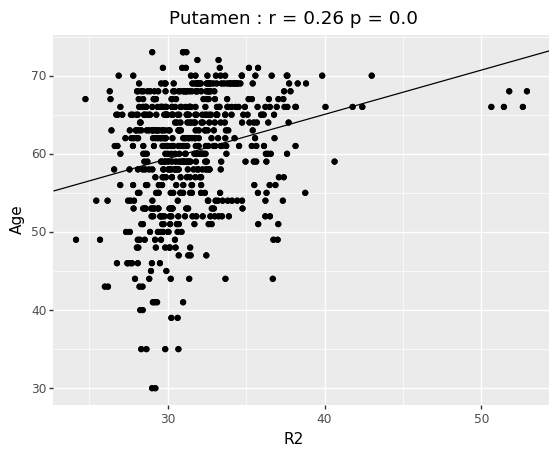

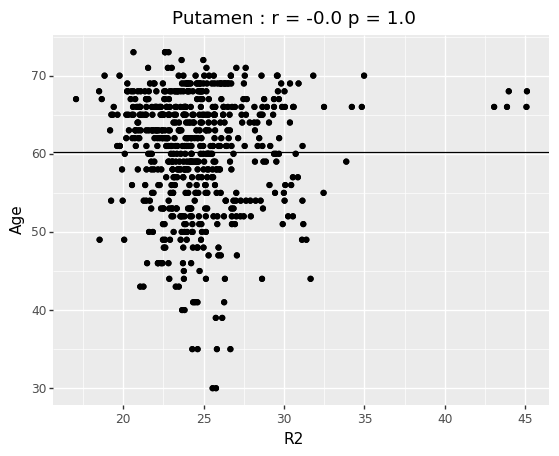

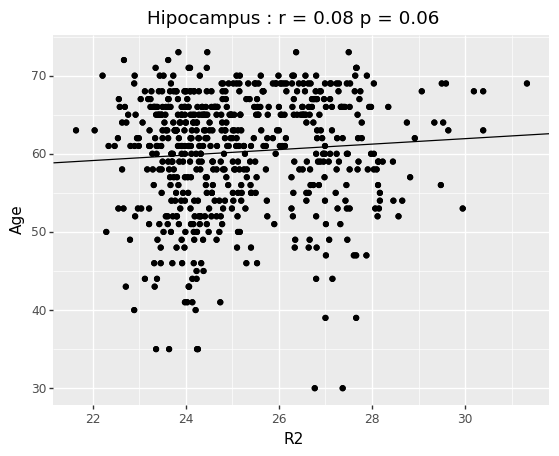

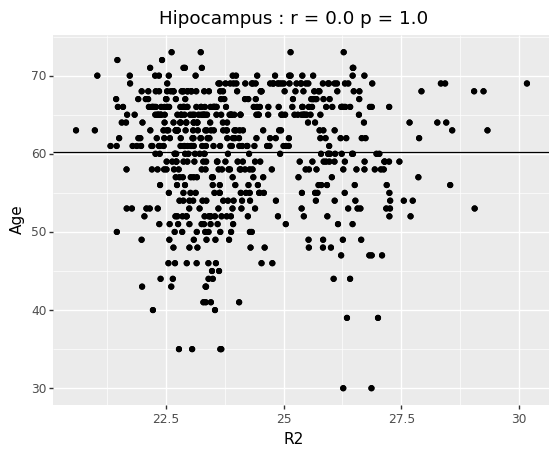

In [86]:
#p9.ggplot(fullDataR2,p9.aes(x='Hipocampus_L',y='Centre'))+p9.geom_point()
for ROI in ["Putamen","Hipocampus"]:
    SCORE='Age'
    X=pd.concat([fullDataR2[ROI+'_L'],fullDataR2[ROI+'_R']], ignore_index=True)
    Y=pd.concat([fullDataR2[SCORE],fullDataR2[SCORE]], ignore_index=True)
    slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
    plot=p9.qplot(X,Y)\
        +p9.geom_point()\
        +p9.xlab('R2')+p9.ggtitle(str(ROI)+' : r = '+str(r_value.round(2))+' p = '+str(p_value.round(3)))\
        +p9.geom_abline(intercept=intercept,slope=slope)
    plot.draw()
    X_corr=unconfound(X.values.reshape(-1, 1),pd.concat([fullDataR2['Age'],fullDataR2['Age']], ignore_index=True).values.reshape(-1, 1),False)
    slope, intercept, r_value, p_value, std_err = stats.linregress(X_corr[:,0], Y)
    plot=p9.qplot(X_corr[:,0],Y)\
        +p9.geom_point()\
        +p9.xlab('R2')+p9.ggtitle(str(ROI)+' : r = '+str(r_value.round(2))+' p = '+str(p_value.round(3)))\
        +p9.geom_abline(intercept=intercept,slope=slope)
    plot.draw()



In [108]:
#p9.ggplot(fullDataR2,p9.aes(x='Hipocampus_L',y='Centre'))+p9.geom_point()
liste_tmp=["Age","Putamen_L","Putamen_L"]
df1=fullDataR2.loc[fullDataR2['Centre']==1][liste_tmp]
#f_stat,pval=stats.f_oneway(cluster1[col].values,cluster2[col].values,cluster3[col].values)
fullDataR2.head()

,Age,Duree,Poids,BMI,MOCA,Sexe,Centre,UPDRS-III_Tot,DOPA,HOEHN_YAHR_ON,...,SubstantiaNegra_L,SubstantiaNegra_R,GPe_L,GPe_R,GPi_L,GPi_R,STh_L,STh_R,Striatum_L,Striatum_R
PatientID,,,,,,,,,,,,,,,,,,,,,
01011BB,51,7.0,81.0,32.446723,0,2.0,1,25,76.0,1.0,...,31.55,34.07,35.72,36.76,30.16,29.23,26.10,25.59,26.23,24.65
01014DE,57,8.0,68.0,26.562500,26,2.0,1,34,88.2,1.0,...,39.07,38.76,40.65,40.83,35.72,33.81,27.93,27.97,30.09,28.51
01015HC,52,25.0,83.0,27.732300,0,2.0,1,93,76.3,3.0,...,48.75,38.66,48.65,48.18,43.65,44.32,27.03,27.72,31.39,30.17
01016BP,52,11.0,71.0,24.567474,26,2.0,1,36,61.1,2.0,...,47.57,43.47,39.90,42.88,36.87,35.78,26.17,26.67,30.04,31.70
01018MT,50,20.0,73.0,24.391059,27,1.0,1,47,89.4,0.0,...,33.65,29.94,32.45,30.94,30.94,28.92,26.47,26.45,29.25,29.37


/home/romain/.local/lib/python3.7/site-packages/plotnine/ggplot.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/romain/.local/lib/python3.7/site-packages/plotnine/ggplot.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


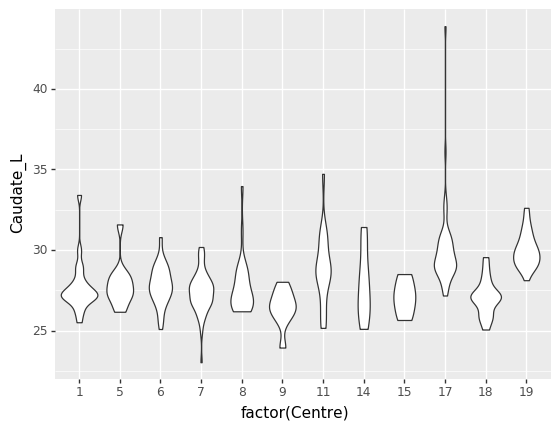

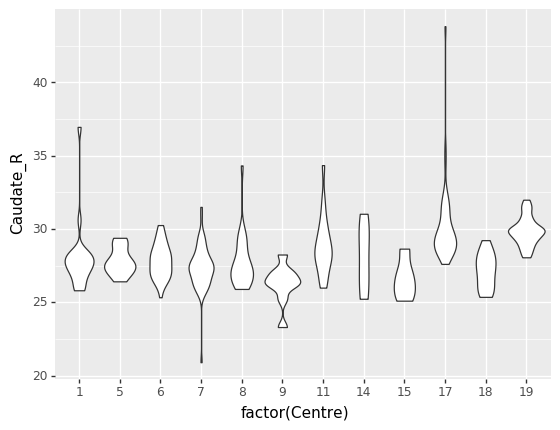

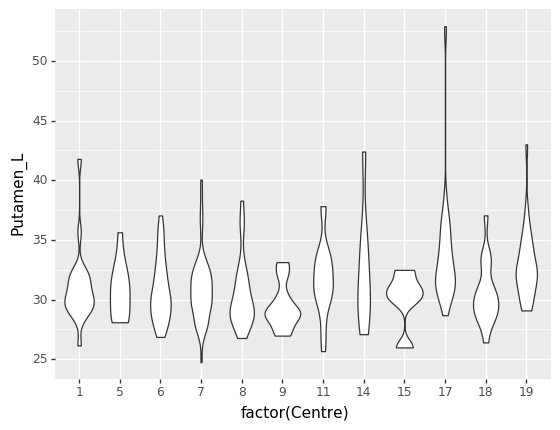

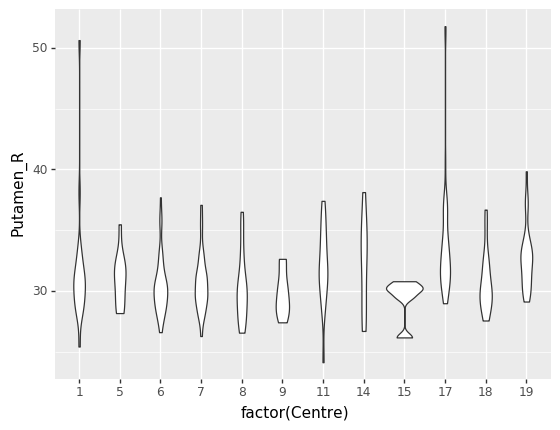

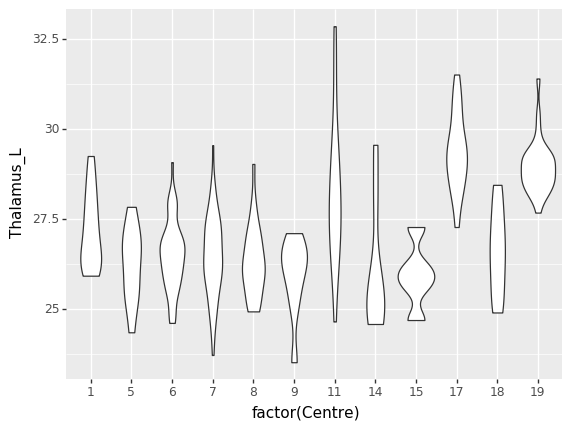

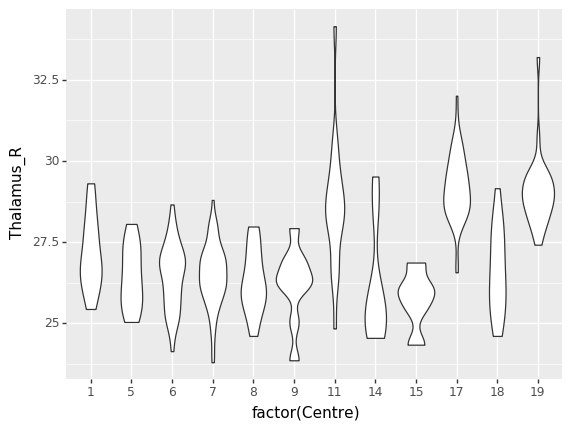

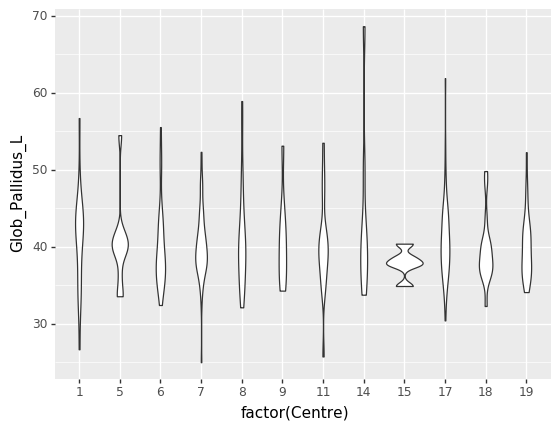

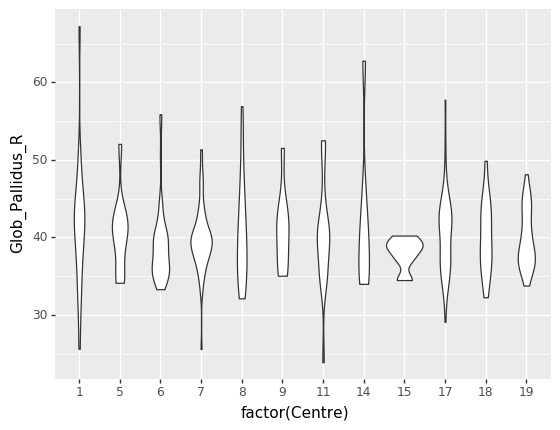

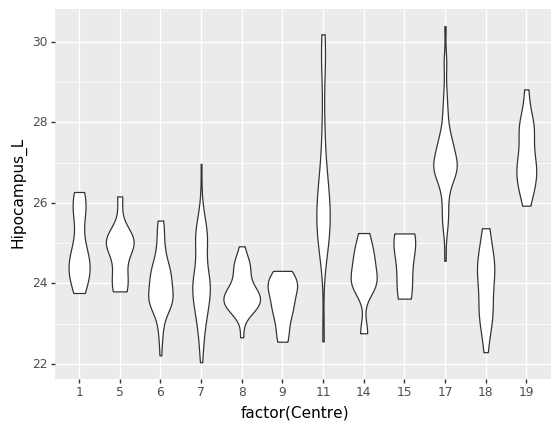

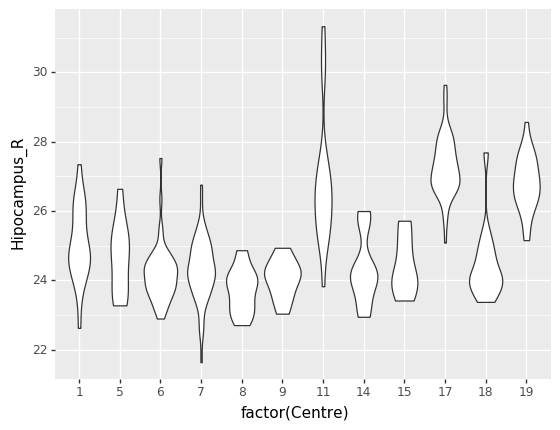

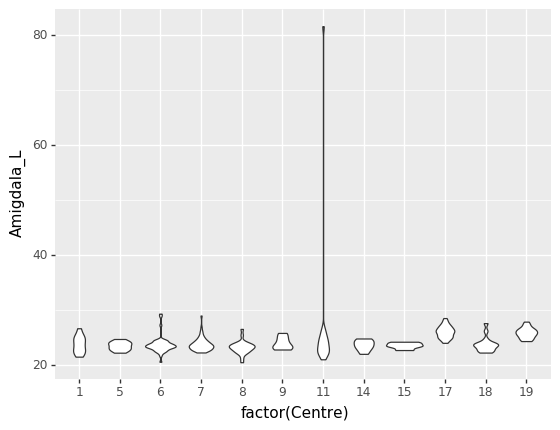

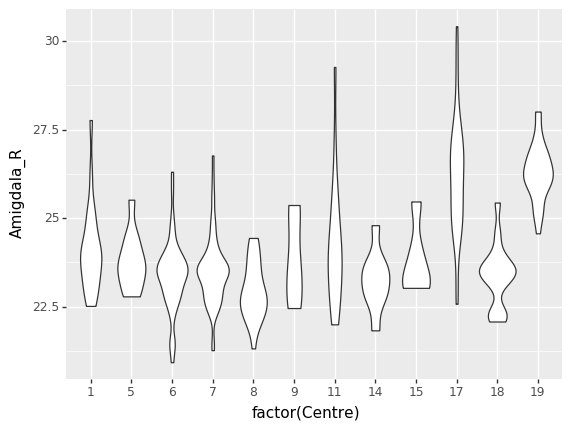

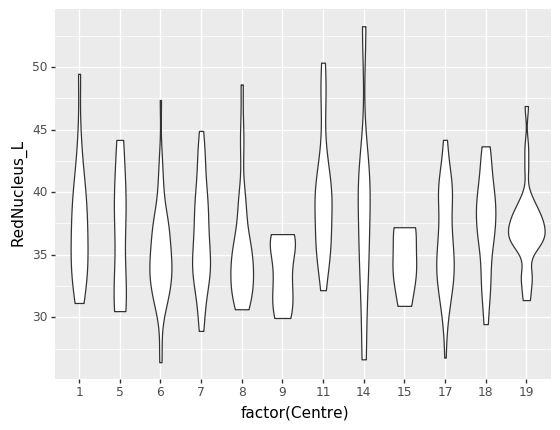

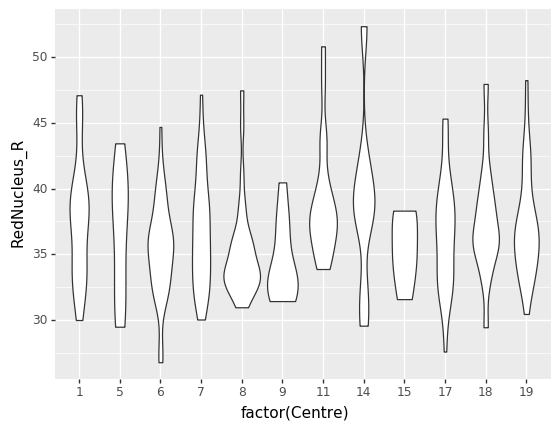

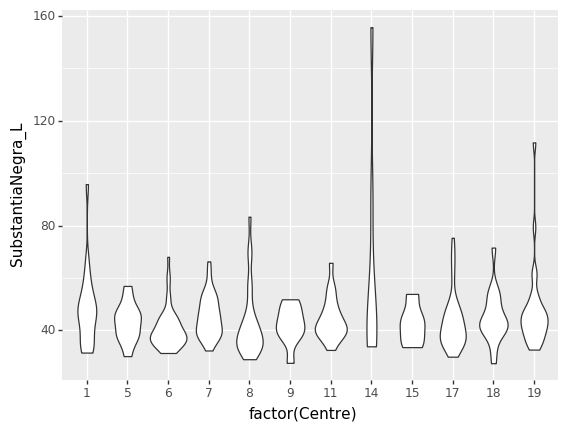

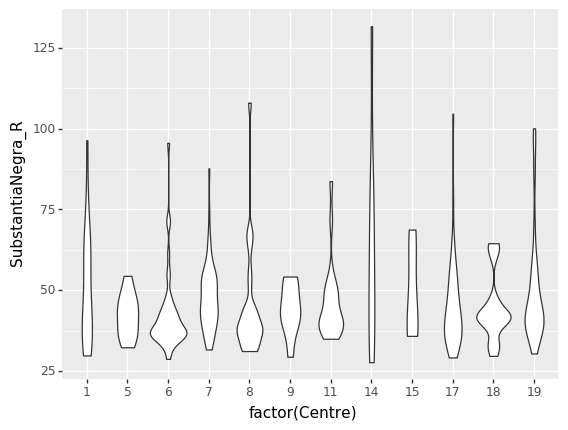

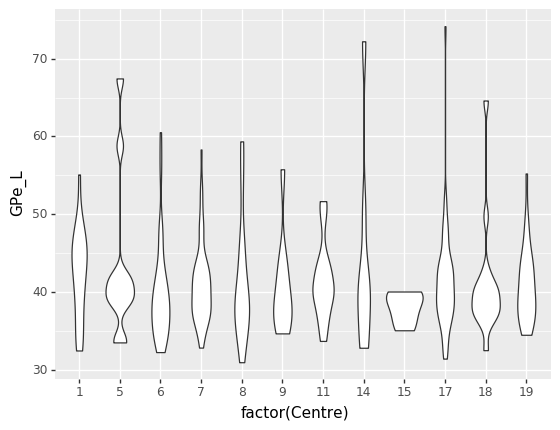

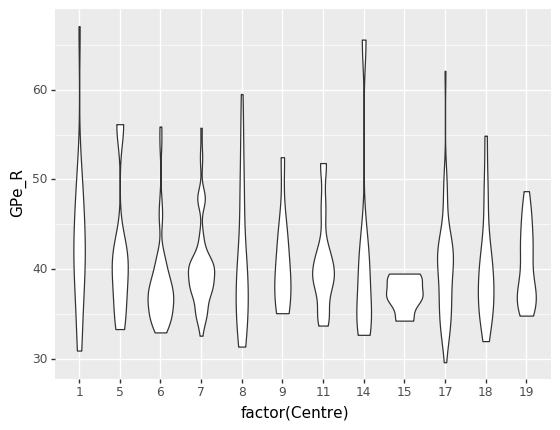

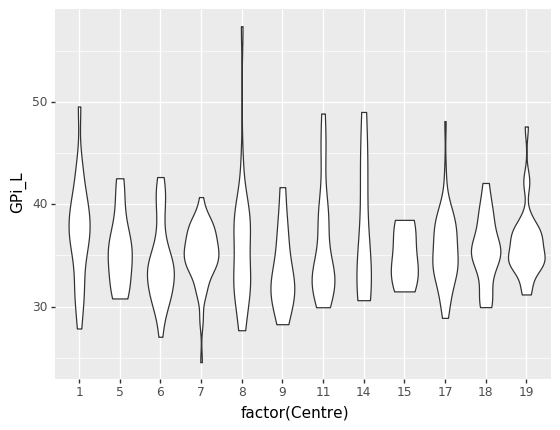

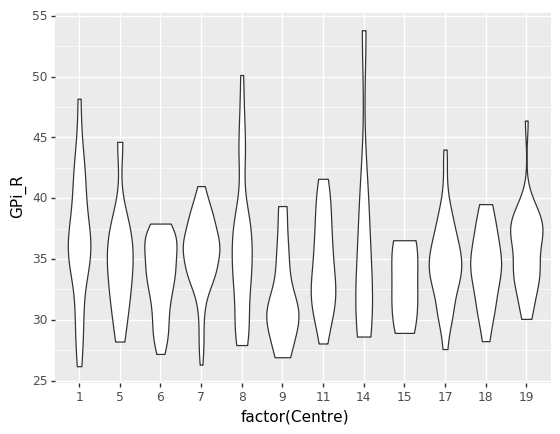

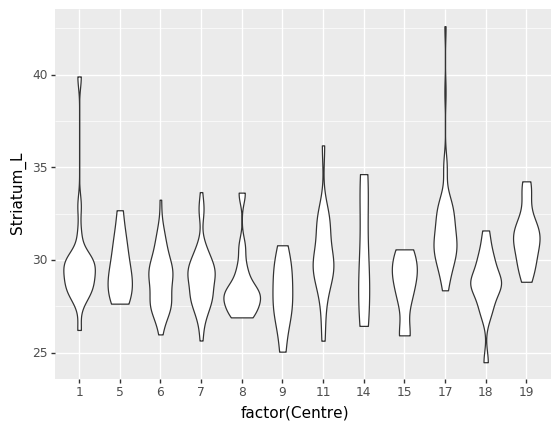

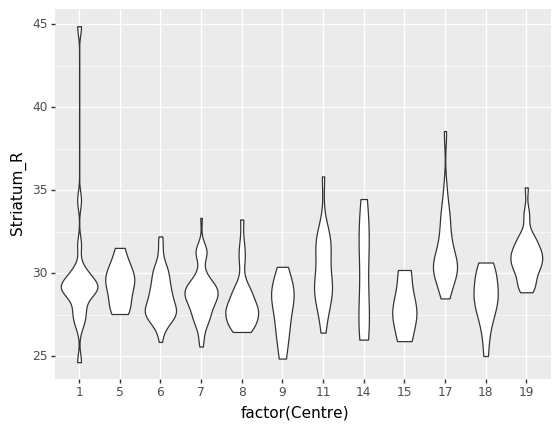

In [114]:
#plot=p9.ggplot(fullDataR2,p9.aes(x='Age', y='Putamen_L'))
#plot.draw()

liste_struct=['Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Thalamus_L', 'Thalamus_R', 'Glob_Pallidus_L', 'Glob_Pallidus_R', 'Hipocampus_L', 'Hipocampus_R', 'Amigdala_L', 'Amigdala_R','RedNucleus_L', 'RedNucleus_R', 'SubstantiaNegra_L', 'SubstantiaNegra_R', 'GPe_L', 'GPe_R', 'GPi_L', 'GPi_R', 'Striatum_L', 'Striatum_R']
for struct in liste_struct: 
    plot=p9.ggplot(fullDataR2,p9.aes(x='factor(Centre)', y=struct)) + p9.geom_violin()
    plot.draw()

In [104]:
arr = [11, 12, 13]
df = pd.DataFrame({'alpha': [1, 2, 3],
                   'beta': [1, 2, 3],
                   'gam ma': [1, 2, 3]})

# Refer to a column in a dataframe
p9.ggplot(df,p9.aes(x='alpha', y='beta'))
p9.draw()

AttributeError: module 'plotnine' has no attribute 'draw'

### Utilisation des clusters de patients pour R2

In [110]:
clusters = pd.read_excel(os.path.join(STUDY_PATH,'patients_clusters.xlsx'),index_col=0)
ind1=clusters.loc[clusters['CLUSTER']==1].index
ind2=clusters.loc[clusters['CLUSTER']==2].index
ind3=clusters.loc[clusters['CLUSTER']==3].index

df = pd.read_csv(os.path.join(STUDY_PATH,'subj4R2_4cluster'+'.csv'),sep='\t',index_col=0)
liste_struct=['Caudate_L','Caudate_R','Putamen_L','Putamen_R','Thalamus_L','Thalamus_R','Glob_Pallidus_L','Glob_Pallidus_R','Hipocampus_L','Hipocampus_R','Amigdala_L','Amigdala_R','Cing_Ant_L','Cing_Ant_D','Front_Sup_L','Front_Sup_R','RedNucleus_L','RedNucleus_R','SubstantiaNegra_L','SubstantiaNegra_R','GPe_L','GPe_R','GPi_L','GPi_R','STh_L','STh_R','Striatum_L','Striatum_R']
np_data = np.loadtxt(os.path.join(STUDY_PATH,'R2_values'+'.csv'))
np_data = stats.zscore(np_data,axis=0)
df2 = pd.DataFrame(data=np_data,columns=liste_struct,index=df.index)
fullData=pd.concat([df,df2],axis=1)
fullData.corr().round(2)
#fullData.index.drop('06051EE')

cluster1=fullData.loc[fullData.index.intersection(ind1)]
print(len(cluster1))
cluster2=fullData.loc[fullData.index.intersection(ind2)]
print(len(cluster2))
cluster3=fullData.loc[fullData.index.intersection(ind3)]
print(len(cluster3))

83
66
14


In [104]:
for col in fullData.columns[14:29]:
    print(col)
    f_stat,pval=stats.f_oneway(cluster1[col].values,cluster2[col].values,cluster3[col].values)
    print(f_stat.round(2),pval.round(2))

Caudate_R
1.66 0.19
Putamen_L
0.11 0.89
Putamen_R
0.11 0.9
Thalamus_L
1.2 0.3
Thalamus_R
0.95 0.39
Glob_Pallidus_L
1.72 0.18
Glob_Pallidus_R
1.36 0.26
Hipocampus_L
1.38 0.25
Hipocampus_R
0.16 0.85
Amigdala_L
0.93 0.4
Amigdala_R
2.29 0.1
Cing_Ant_L
nan nan
Cing_Ant_D
nan nan
Front_Sup_L
nan nan
Front_Sup_R
nan nan


### Utilisation des clusters de patients pour QSM

In [101]:
clusters = pd.read_excel(os.path.join(STUDY_PATH,'patients_clusters.xlsx'),index_col=0)
ind1=clusters.loc[clusters['CLUSTER']==1].index
ind2=clusters.loc[clusters['CLUSTER']==2].index
ind3=clusters.loc[clusters['CLUSTER']==3].index

#fullData = pd.read_excel(os.path.join(STUDY_PATH,'QSM_values.xlsx'),index_col=0)
df = pd.read_csv(os.path.join(STUDY_PATH,'subj4QSM_4cluster'+'.csv'),sep='\t',index_col=0)
liste_struct=['Caudate_L','Caudate_R','Putamen_L','Putamen_R','Thalamus_L','Thalamus_R','Glob_Pallidus_L','Glob_Pallidus_R','Hipocampus_L','Hipocampus_R','Amigdala_L','Amigdala_R','Cing_Ant_L','Cing_Ant_D','Front_Sup_L','Front_Sup_R','RedNucleus_L','RedNucleus_R','SubstantiaNegra_L','SubstantiaNegra_R','GPe_L','GPe_R','GPi_L','GPi_R','STh_L','STh_R','Striatum_L','Striatum_R']
np_data = np.loadtxt(os.path.join(STUDY_PATH,'QSM_values'+'.csv'))
np_data = stats.zscore(np_data,axis=0)
df2 = pd.DataFrame(data=np_data,columns=liste_struct,index=df.index)
fullData=pd.concat([df,df2],axis=1)
fullData.corr().round(2)

cluster1=fullData.loc[fullData.index.intersection(ind1)]
print(len(cluster1))
cluster2=fullData.loc[fullData.index.intersection(ind2)]
print(len(cluster2))
cluster3=fullData.loc[fullData.index.intersection(ind3)]
print(len(cluster3))

22
11
8


In [100]:
for col in fullData.columns[14:29]:
    print(col)
    f_stat,pval=stats.f_oneway(cluster1[col].values,cluster2[col].values,cluster3[col].values)
    print(f_stat.round(2),pval.round(2))

Caudate_R
0.66 0.52
Putamen_L
0.07 0.93
Putamen_R
0.49 0.62
Thalamus_L
0.12 0.88
Thalamus_R
0.84 0.44
Glob_Pallidus_L
0.05 0.95
Glob_Pallidus_R
0.59 0.56
Hipocampus_L
0.69 0.51
Hipocampus_R
0.02 0.98
Amigdala_L
0.23 0.8
Amigdala_R
0.51 0.6
Cing_Ant_L
0.17 0.85
Cing_Ant_D
0.91 0.41
Front_Sup_L
0.45 0.64
Front_Sup_R
0.84 0.44


MeanQSM.xlsx MeanR2.xlsx 
MeanR2WoNanInR2.xlsx MeanQSMWoNaninIma.xlsx 

MeanQSMWoNaN.xlsx MeanR2WoNan.xlsx
MeanR2WoNaNWoOutliers.xlsx MeanQSMWoNaNWoOutliers.xlsx

In [8]:
for db in ['MeanQSM','MeanR2','MeanR2WoNanInR2','MeanQSMWoNanInQSM','MeanQSMWoNaN','MeanR2WoNan','MeanR2WoNaNWoOutliers','MeanQSMWoNaNWoOutliers']: 
    ClinicalData = pd.read_excel(os.path.join(STUDY_PATH,db+'.xlsx'))
    print(db)
    print(len(ClinicalData))

MeanQSM
116
MeanR2
399
MeanR2WoNanInR2
361
MeanQSMWoNaninIma
31
MeanQSMWoNaN
78
MeanR2WoNan
282
MeanR2WoNaNWoOutliers
278
MeanQSMWoNaNWoOutliers
78


In [321]:
print(ClinicalData.loc[ClinicalData['Poids']==0])
ClinicalData['Poids'].replace(0,'NaN')
print(test.loc[test['Poids']==0])

           Age  Sexe  Duree  Poids  BMI  MOCA  UPDRS-III_Tot  DOPA  \
PatientID                                                            
01031FB     54   1.0   14.0    0.0  NaN    26             44  84.1   
01048LJ     66   1.0   11.0    0.0  NaN     0             34  94.1   
01050ME     55   1.0    9.0    0.0  NaN     0             46  60.9   
19050PM     70   2.0    7.0    0.0  NaN    27             19  89.5   
19051FJ     59   1.0    7.0    0.0  NaN    29             29  82.8   

           HOEHN_YAHR_ON  HOEHN_YAHR_OFF  SCHWAB_ON  SCHWAB_OFF  Centre  
PatientID                                                                
01031FB              1.0             4.0       10.0         7.0       1  
01048LJ              1.0             2.5       10.0         8.0       1  
01050ME              1.0             2.0       10.0         9.0       1  
19050PM              2.0             3.0       10.0         8.0      19  
19051FJ              1.0             4.0        9.0         3.0  

KeyError: 'Poids'

In [285]:
print(ClinicalData['BMI'].isnull().sum())
print(ClinicalData.loc[ClinicalData['BMI'].isnull()].index)

print(len(ClinicalData.loc[ClinicalData['MOCA']==0]))

6
Index(['01031FB', '01044SD', '01048LJ', '01050ME', '19050PM', '19051FJ'], dtype='object', name='PatientID')
38


In [284]:
print(ClinicalData.loc[ClinicalData['Duree'].isnull()].index)

Index([], dtype='object', name='PatientID')


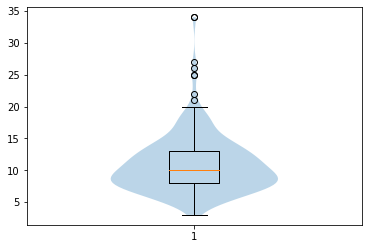

In [269]:
plt.violinplot(np.array(ClinicalData['Duree'].dropna().values),showextrema=False)
plt.boxplot(np.array(ClinicalData['Duree'].dropna().values))
plt.show()
plt.violinplot(np.array(ClinicalData['Duree'].dropna().values),showextrema=False)
plt.boxplot(np.array(ClinicalData['Duree'].dropna().values))
plt.show()

In [268]:
ClinicalData['Duree'].dropna().values

array([ 7.,  8., 25., 11., 20., 10., 13., 14.,  9., 17.,  9., 18., 16.,
       10., 14., 14.,  9., 11.,  9.,  5., 15., 14., 11.,  8., 12.,  7.,
       10., 10., 17.,  7., 13., 11.,  9., 10.,  6.,  6.,  6.,  7.,  7.,
       19., 11.,  6., 10., 12., 18.,  9., 34.,  5.,  9., 16.,  6.,  6.,
        9., 10.,  6., 13.,  8., 14.,  5., 19.,  9., 13.,  9., 15., 15.,
       10., 12., 10.,  8.,  6.,  8.,  7.,  9., 15.,  7.,  9.,  7.,  8.,
        8., 13., 13.,  8.,  9.,  5., 16., 19., 10., 12.,  8.,  7., 11.,
        9., 14.,  9., 13., 11.,  8., 12.,  8., 17.,  7.,  7., 13.,  6.,
        8.,  3., 11.,  6.,  9., 14.,  5., 10., 11., 12.,  8., 15.,  7.,
       14., 13., 12., 10.,  5., 14.,  7.,  7., 11.,  9., 14., 11.,  7.,
        9., 11.,  6., 12., 12.,  5., 11., 15.,  8., 15.,  6., 10., 10.,
       12., 12., 11., 34.,  5., 11., 26., 12., 12.,  8.,  8.,  8.,  8.,
        8., 12., 18., 13.,  9.,  7., 14., 10.,  8.,  8., 11., 19.,  9.,
        7.,  9., 10., 11., 13., 12., 10., 13.,  9., 12.,  7.,  9

In [4]:
df_R2 = pd.read_excel(os.path.join(STUDY_PATH,'MeanR2WoNanInR2.xlsx'))
np.abs(df_R2.corr())

,Age,Sexe,Duree,Poids,BMI,MOCA,UPDRS-III_Tot,DOPA,HOEHN_YAHR_ON,HOEHN_YAHR_OFF,...,Right_globus_pallidus,Left_hippocampus,Right_hippocampus,Left_amigdala,Right_amigdala,Left_RedNucleus,Right_RedNucleus,Left_SubstantiaNigra,Right_SubstantiaNigra,ribbon
Age,1.000000,0.177400,0.134860,0.074978,0.030503,0.009854,0.003872,0.130836,0.111546,0.003177,...,0.066846,0.054867,0.010001,0.047592,0.001196,0.111203,0.154895,0.100843,0.098231,0.070689
Sexe,0.177400,1.000000,0.002794,0.254972,0.005466,0.083012,0.073795,0.000216,0.070103,0.065449,...,0.019628,0.100963,0.093723,0.048454,0.078762,0.022151,0.047361,0.114822,0.143471,0.015276
Duree,0.134860,0.002794,1.000000,0.088316,0.014224,0.014724,0.147034,0.069523,0.040232,0.221194,...,0.002689,0.070843,0.055386,0.039601,0.048597,0.052492,0.050387,0.024327,0.014481,0.020576
Poids,0.074978,0.254972,0.088316,1.000000,0.472095,0.140465,0.018881,0.060189,0.021892,0.056032,...,0.026042,0.034270,0.008662,0.106438,0.006151,0.027926,0.024950,0.012608,0.003285,0.010195
BMI,0.030503,0.005466,0.014224,0.472095,1.000000,0.075953,0.027714,0.040010,0.081791,0.005889,...,0.000197,0.029906,0.064123,0.049469,0.041433,0.004814,0.004796,0.011761,0.015150,0.022388
MOCA,0.009854,0.083012,0.014724,0.140465,0.075953,1.000000,0.085384,0.046464,0.042916,0.045953,...,0.004460,0.018278,0.008359,0.058275,0.018093,0.020711,0.021064,0.007235,0.005154,0.043934
UPDRS-III_Tot,0.003872,0.073795,0.147034,0.018881,0.027714,0.085384,1.000000,0.338499,0.252333,0.410427,...,0.030347,0.054842,0.008226,0.046961,0.068895,0.071664,0.047879,0.052312,0.058199,0.085991
DOPA,0.130836,0.000216,0.069523,0.060189,0.040010,0.046464,0.338499,1.000000,0.004907,0.160355,...,0.010009,0.024134,0.006595,0.007183,0.004426,0.011577,0.048192,0.048477,0.017115,0.032061
HOEHN_YAHR_ON,0.111546,0.070103,0.040232,0.021892,0.081791,0.042916,0.252333,0.004907,1.000000,0.439866,...,0.090515,0.086958,0.106623,0.067402,0.088696,0.146543,0.116321,0.160711,0.122282,0.052899
HOEHN_YAHR_OFF,0.003177,0.065449,0.221194,0.056032,0.005889,0.045953,0.410427,0.160355,0.439866,1.000000,...,0.003824,0.055519,0.059725,0.019202,0.047027,0.050115,0.016173,0.073193,0.064669,0.049038


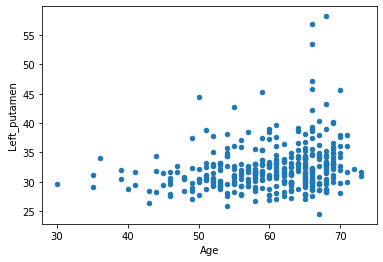

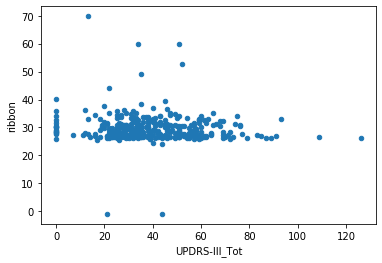

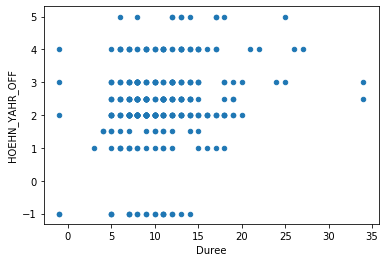

In [255]:
df_R2.plot(x='Age',y='Left_putamen',kind='scatter')
df_R2.plot(x='UPDRS-III_Tot',y='ribbon',kind='scatter')
df_R2.plot(x='Duree',y='HOEHN_YAHR_OFF',kind='scatter')

In [6]:
df_QSM = pd.read_excel(os.path.join(STUDY_PATH,'MeanQSMWoNanInQSM.xlsx'))
np.abs(df_QSM.corr())

,Age,Sexe,Duree,Poids,BMI,MOCA,UPDRS-III_Tot,DOPA,HOEHN_YAHR_ON,HOEHN_YAHR_OFF,...,Right_globus_pallidus,Left_hippocampus,Right_hippocampus,Left_amigdala,Right_amigdala,Left_RedNucleus,Right_RedNucleus,Left_SubstantiaNigra,Right_SubstantiaNigra,ribbon
Age,1.000000,0.115904,0.111960,0.048401,0.051656,0.057395,0.256508,0.032879,0.236375,0.110097,...,0.057047,0.207756,0.059220,0.171723,0.033231,0.115275,0.013818,0.140168,0.013523,0.065109
Sexe,0.115904,1.000000,0.217074,0.376979,0.036260,0.068149,0.216532,0.164208,0.050911,0.132473,...,0.288534,0.256897,0.320761,0.311976,0.153508,0.162359,0.012215,0.007068,0.169024,0.093117
Duree,0.111960,0.217074,1.000000,0.364759,0.185786,0.009316,0.332256,0.189358,0.167798,0.263703,...,0.151067,0.031139,0.202118,0.171966,0.128161,0.285301,0.086451,0.095187,0.223219,0.018113
Poids,0.048401,0.376979,0.364759,1.000000,0.474753,0.276178,0.040486,0.154114,0.199819,0.236684,...,0.022839,0.215661,0.444849,0.384566,0.424474,0.218593,0.033854,0.060171,0.049035,0.515951
BMI,0.051656,0.036260,0.185786,0.474753,1.000000,0.334891,0.007224,0.045578,0.499815,0.182107,...,0.105168,0.018377,0.231400,0.189935,0.287359,0.026977,0.205257,0.225618,0.114833,0.348005
MOCA,0.057395,0.068149,0.009316,0.276178,0.334891,1.000000,0.206218,0.106443,0.199166,0.147876,...,0.097363,0.056445,0.183144,0.176063,0.378683,0.358510,0.114579,0.063352,0.150140,0.295383
UPDRS-III_Tot,0.256508,0.216532,0.332256,0.040486,0.007224,0.206218,1.000000,0.076367,0.018839,0.149442,...,0.272947,0.176336,0.105658,0.074426,0.155805,0.168870,0.186160,0.181252,0.440664,0.243557
DOPA,0.032879,0.164208,0.189358,0.154114,0.045578,0.106443,0.076367,1.000000,0.150490,0.188226,...,0.087236,0.018368,0.026061,0.011756,0.128126,0.005787,0.063987,0.181007,0.000474,0.184518
HOEHN_YAHR_ON,0.236375,0.050911,0.167798,0.199819,0.499815,0.199166,0.018839,0.150490,1.000000,0.517004,...,0.243191,0.115711,0.112761,0.045714,0.114566,0.141583,0.341342,0.226300,0.266783,0.329977
HOEHN_YAHR_OFF,0.110097,0.132473,0.263703,0.236684,0.182107,0.147876,0.149442,0.188226,0.517004,1.000000,...,0.235294,0.157797,0.246523,0.193400,0.175618,0.294682,0.377835,0.340091,0.356193,0.303892


In [7]:
for ROI in ['putamen']:
    X=pd.concat([std_good['R2 Left '+str(ROI)],std_good['R2 Right '+str(ROI)]], ignore_index=True)
    Y=pd.concat([std_good['QSM Left '+str(ROI)],std_good['QSM Right '+str(ROI)]], ignore_index=True)
    #print(X.describe())
    #print(Y.describe())
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
    plot=gg.qplot(X,Y)\
    +gg.geom_point()\
    +gg.xlab('R2')+gg.ylab('QSM')+gg.ggtitle(str(ROI)+' : r = '+str(r_value))\
    +gg.geom_abline(intercept=intercept,slope=slope)
    plot.show()
    plot.save(DIR+'screenshots/R2_QSM_corr/'+ROI+'.tiff',dpi = 300)

NameError: name 'std_good' is not defined

In [35]:
df_QSM.loc['19047MA']

KeyError: '19047MA'